*Note: Due to a family emergency I only had around a day to really try this out, so i'm sorry for inevitable spelling mistakes and poor figure labelling!*


#**Section II - Machine learning task**



---



##Dataset overview


* Wind turbine SCADA data from February 2018 – January 2019 (What is SCADA? See this doc)
*  SCADA data is saved at 10 minute intervals.
* Each CSV file contains 44 wind turbines
* Description of column headers
* Station ID – Wind turbine ID numbers in the windfarm
* Use the following tags for the model
  * Generator bearing 1
    * wtc_GenBeGTm_min
    * wtc_GenBeGTm_max
    * wtc_GenBeGTm_mean
  * Generator bearing 2
    * wtc_GenBeRTm_min
    * wtc_GenBeRTm_max
    * wtc_GenBeRTm_mean
* All temperature values are in Celsius (°C)

* Link to data
* Confidentiality – The data you access is strictly confidential. By accessing the data, you agree NOT to use the data for any purpose except performing this task. No distribution is allowed. After you complete the task, the data should be immediately deleted from your local device.



---



##**Problem description**

During the historical data collection period, several wind turbines had generator bearing
problems. Four wind turbines had generator bearing failures and replacements. The symptom of
bearing fault is rising temperature beyond normal range.
The task is to build the ML model to detect anomaly in generator bearing and identify wind
turbines that shows generator bearing defect.

###**The candidates are required to submit the following:**
* List of WT’s that are suspected to have a generator bearing defect during the data period
including 4 that had change out
* Result showing the reason for diagnosis
* Code

###**Useful information**
* Wind turbines that had NO generator bearing defect (healthy) - 2301750, 2301745,
2301762, 2301728, 2301752, 2301741



---

## Examining the data



In [0]:
# Importing some things that we'll likely need for this task

import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path

%matplotlib inline

In [2]:
# Initially, I'd like to have a look at the folder structure and the files, 
# to get a handle on them.


from google.colab import drive    # Mount the data
drive.mount('/content/gdrive')    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Lets set up the root path, and then have a look to see what the file and 
# folder structure looks like

root_path = Path('/content/gdrive/My Drive/Home/Jobs/ONYX/SCADA')


# This is a useful little function to let us see what files and folders are in 
# given path
Path.ls = lambda x: [o.name for o in x.iterdir()]

file_locations = []
for data_path in sorted(root_path.ls()):
  path = root_path/data_path
  print('-{}'.format(data_path))
  if path.is_dir():
    for file in sorted(path.ls()):
      print('    -{}'.format(file))
      file_locations.append(path/file)   # While we're here, lets save these



-2018-02
    -2018-02-tmp.csv
-2018-03
    -2018-03-tmp.csv
-2018-04
    -2018-04-tmp.csv
-2018-05
    -2018-05-tmp.csv
-2018-06
    -2018-06-tmp.csv
-2018-07
    -2018-07-tmp.csv
-2018-08
    -2018-08-tmp.csv
-2018-09
    -2018-09-tmp.csv
-2018-10
    -2018-10-tmp.csv
-2018-11
    -2018-11-tmp.csv
-2018-12
    -2018-12-tmp.csv
-2019-01
    -2019-01-tmp.csv
-full_table.csv



So lets note down the important information first
  * Root Folder
    * folders formatted YYYY-MM, 12 in total.
      * files formatted YYYY-MM-tmp.csv, 1 per folder
  * Initial folder is 2018-02, final is 2019-01 (Playing with real and current data! Cool!)
  * Each file is ~150 Mb, so ~1.8 Gb total dataset size.
  * All files are .csv

 
Lets open up the 2018-02 file to begin with, and see what the files actually look like. Since these are all CV's, pandas seems like the best 
way to begin exploring this

In [0]:
data_single_month = pd.read_csv(file_locations[0])

In [6]:
# What columns are in the data, and how many are there

print('Num. Columns: {}'.format(len(data_single_month.columns)))
print('Num. Rows: {}'.format(len(data_single_month)))
#list(data_single_month.columns.values)    # Commented, because it's long, had 
                                           # a look though.

Num. Columns: 134
Num. Rows: 176926


In [7]:
# What does the data actually look like
data_single_month.head(10)

,TimeStamp,StationId,wtc_A1ExtTmp_min,wtc_A1ExtTmp_max,wtc_A1ExtTmp_mean,wtc_A1IntTmp_min,wtc_A1IntTmp_max,wtc_A1IntTmp_mean,wtc_A2IntTmp_min,wtc_A2IntTmp_max,...,wtc_ReacVTmp_mean,wtc_ReacVTmp_stddev,wtc_ReacWTmp_min,wtc_ReacWTmp_max,wtc_ReacWTmp_mean,wtc_ReacWTmp_stddev,wtc_MainBTmp_min,wtc_MainBTmp_max,wtc_MainBTmp_mean,wtc_MainBTmp_stddev
0,2/1/18 0:00,2301722,9,10,9.515133,27,27,27.000000,25,25,...,38.835320,1.929584,36,43,38.996132,1.951730,19,20,19.001671,0.040791
1,2/1/18 0:00,2301723,8,9,8.040100,16,17,16.649771,22,22,...,55.686470,0.909907,49,51,50.254570,0.797598,18,19,18.818199,0.385680
2,2/1/18 0:00,2301724,6,8,7.121500,24,25,24.295080,24,24,...,34.700729,0.921687,31,34,32.199379,0.849115,25,25,25.000000,0.000000
3,2/1/18 0:00,2301725,6,7,6.084116,20,21,20.942720,24,25,...,49.324749,0.468281,46,47,46.935799,0.245109,22,23,22.398781,0.489648
4,2/1/18 0:00,2301726,8,8,8.000000,22,22,22.000000,18,19,...,50.563702,0.495926,48,50,48.713200,0.459579,19,19,19.000000,0.000000
5,2/1/18 0:00,2301727,7,8,7.880100,25,26,25.063650,25,25,...,30.381100,0.857513,32,36,34.624100,1.221611,20,20,20.000000,0.000000
6,2/1/18 0:00,2301728,7,7,7.000000,27,27,27.000000,25,25,...,30.149380,0.541173,27,29,28.039631,0.291541,25,25,25.000000,0.000000
7,2/1/18 0:00,2301729,7,7,7.000000,18,18,18.000000,22,22,...,24.000000,0.000000,24,24,24.000000,0.000000,17,17,17.000000,0.000000
8,2/1/18 0:00,2301730,7,8,7.519933,25,25,25.000000,13,22,...,39.525848,0.543843,38,39,38.615768,0.486414,20,20,20.000000,0.000000
9,2/1/18 0:00,2301731,5,6,5.341217,18,18,18.000000,22,23,...,24.004080,0.063770,19,20,19.146469,0.353573,18,18,18.000000,0.000000


In [0]:
# Now at this point i'd normally describe the data too, but we've been given 
# specific features to model on, so lets reduce our data to that.
# We'll keep the timestamp in, because this is clearly time series data,
# and this will therefore likely be useful.

features = ['TimeStamp','StationId','wtc_GenBeGTm_min','wtc_GenBeGTm_mean',
            'wtc_GenBeGTm_max','wtc_GenBeRTm_min','wtc_GenBeRTm_mean',
            'wtc_GenBeRTm_max']


data_single_month = data_single_month[features]

In [9]:
# With reduced features, what do all 44 of the turbines look like?

data_single_month.head(44)

,TimeStamp,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_mean,wtc_GenBeGTm_max,wtc_GenBeRTm_min,wtc_GenBeRTm_mean,wtc_GenBeRTm_max
0,2/1/18 0:00,2301722,35,35.668949,36,24,24.041450,25
1,2/1/18 0:00,2301723,41,41.000000,41,22,22.000000,22
2,2/1/18 0:00,2301724,36,36.196751,37,24,24.000000,24
3,2/1/18 0:00,2301725,32,32.000000,32,25,25.321880,26
4,2/1/18 0:00,2301726,33,33.534199,34,21,21.000000,21
5,2/1/18 0:00,2301727,43,43.000000,43,34,34.000000,34
6,2/1/18 0:00,2301728,37,37.000000,37,24,24.000000,24
7,2/1/18 0:00,2301729,30,30.000000,30,19,19.000000,19
8,2/1/18 0:00,2301730,41,41.188400,42,23,23.000000,23
9,2/1/18 0:00,2301731,31,31.000000,31,21,21.999670,22


In [10]:
# That's a bit nicer to look at. How do the statistics match up?

data_single_month.describe()

,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_mean,wtc_GenBeGTm_max,wtc_GenBeRTm_min,wtc_GenBeRTm_mean,wtc_GenBeRTm_max
count,1.769260e+05,176926.000000,176926.000000,176926.000000,176926.000000,176926.000000,176926.000000
mean,2.301743e+06,31.767213,32.084946,32.406051,23.041396,23.351864,23.662757
std,1.270547e+01,18.997163,19.028966,19.066865,15.428071,15.437375,15.456262
min,2.301722e+06,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000
25%,2.301732e+06,20.000000,20.000000,20.000000,15.000000,15.000000,16.000000
50%,2.301743e+06,29.000000,29.754800,30.000000,22.000000,22.000000,22.000000
75%,2.301755e+06,41.000000,41.477240,42.000000,28.000000,28.752500,29.000000
max,2.301765e+06,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000


In [11]:
# and are all the numerics valid?

not data_single_month.isnull().values.any()

True

**File Structure**
* 8 columns
  * 7 numeric, 1 datetime
  * Unique ID column is StationId
* **Timeseries data**
* No obvious labels or classification
  * So we're dealing with unclassified, timeseries data (Markov?)
  
 Lets get a closer look at the data. Thankfully, we know at least 6 tubrines are well behaved, so they seem like a good place to start to get a handle on what *normal* data looks like in these situations

In [0]:
# The following turbines are known to be healthy,
# this could prove to be a useful test.


healthy_turbine_IDs = [2301750, 2301745, 2301762, 2301728, 
                                        2301752, 2301741]

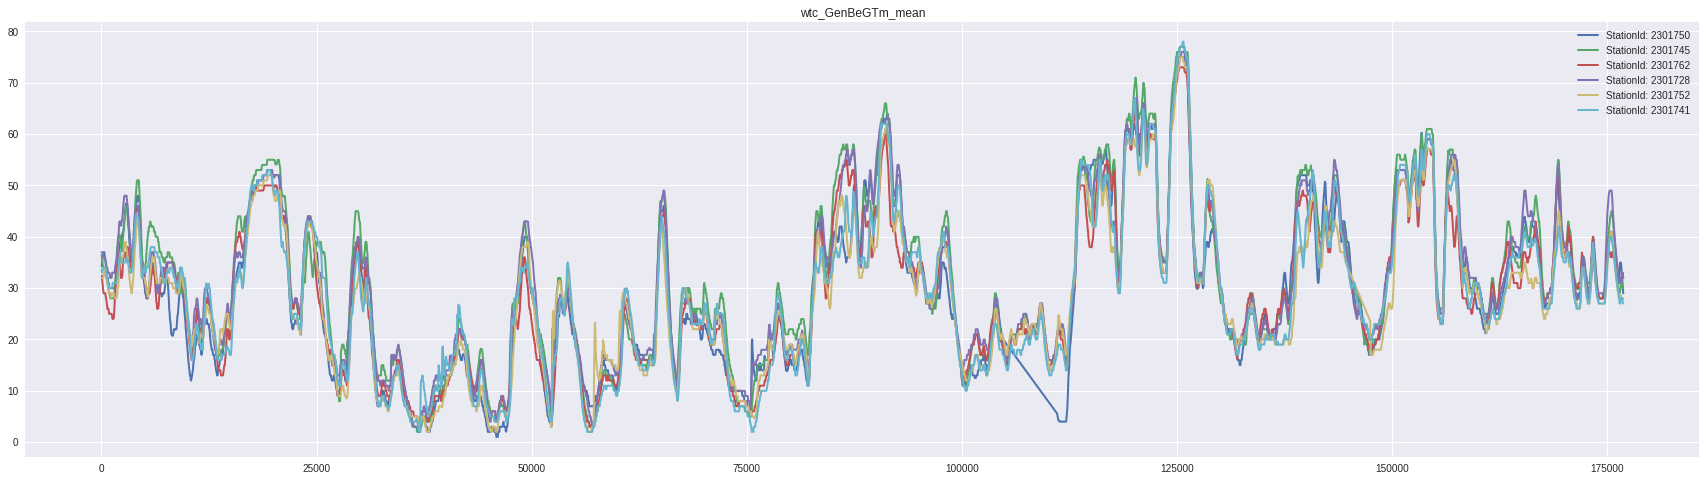

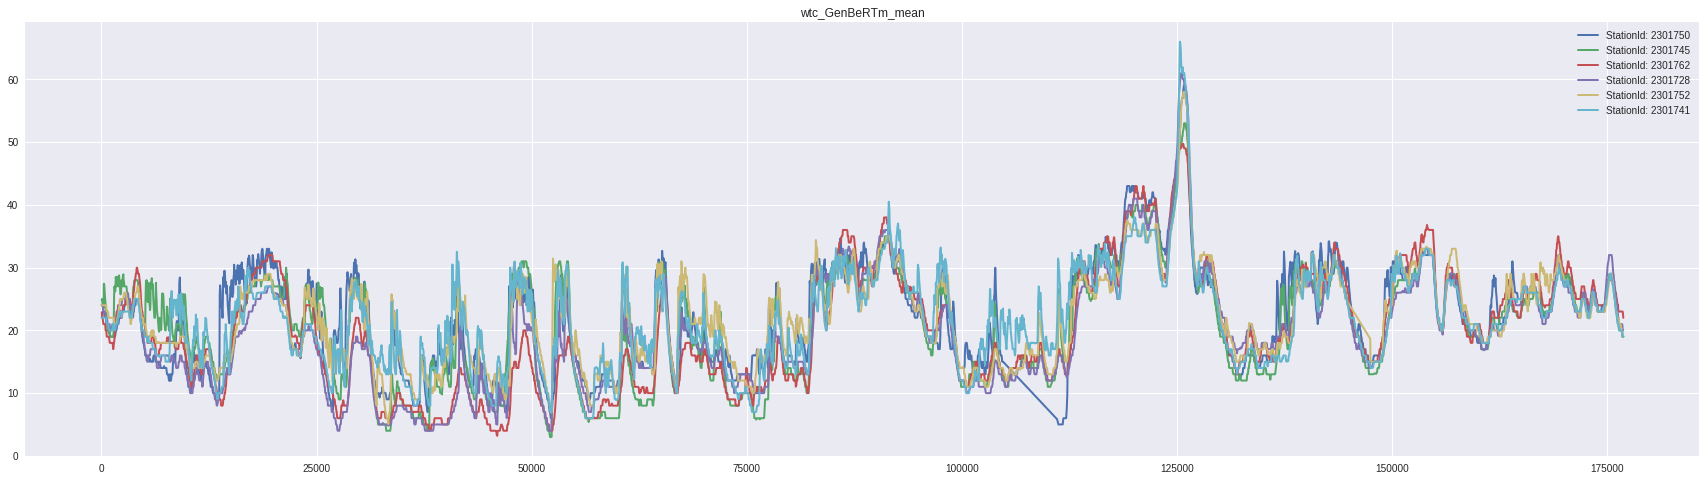

In [13]:
# Lets plot these up as a time series, to get a handle on what they should look
# like

fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  data_single_month[data_single_month['StationId'] == turbine].plot(
      y='wtc_GenBeGTm_mean', figsize=(30,8), fig = fig, ax = ax, 
      label='StationId: ' +str(turbine), lw = 2, alpha =1,
      title = 'wtc_GenBeGTm_mean')
  
fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  data_single_month[data_single_month['StationId'] == turbine].plot(
      y='wtc_GenBeRTm_mean', figsize=(30,8), fig = fig, ax = ax, lw = 2, 
      label='StationId: ' +str(turbine), alpha =1, title = 'wtc_GenBeRTm_mean')

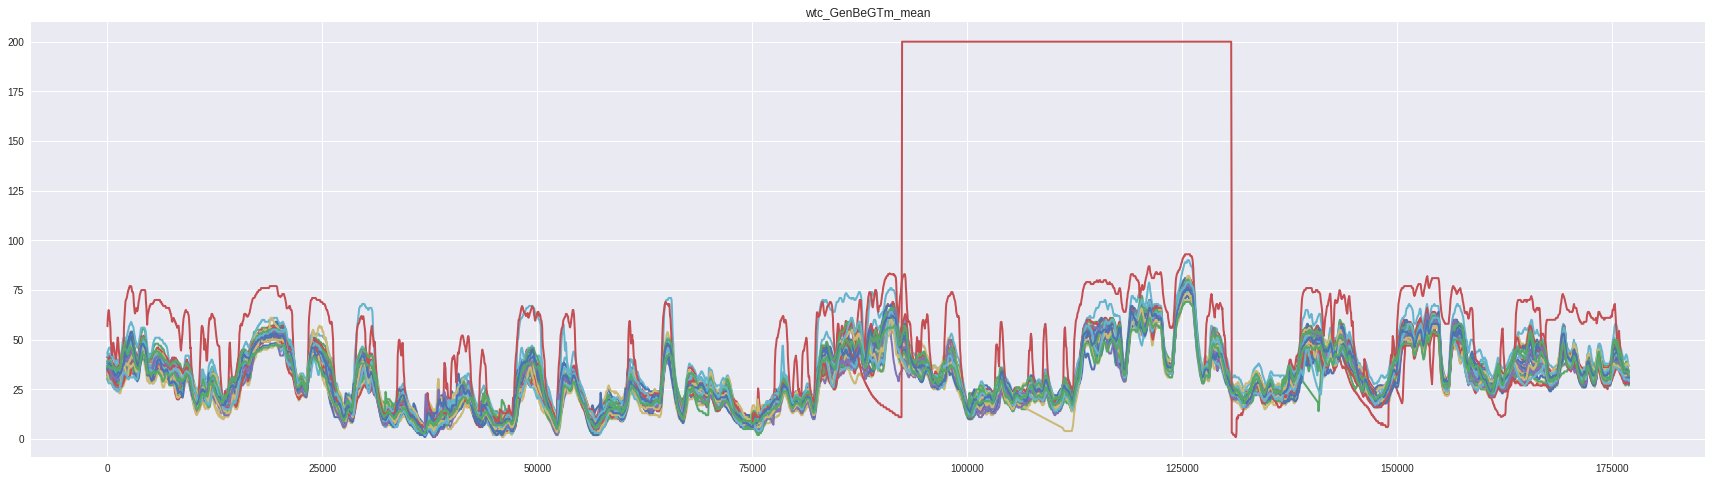

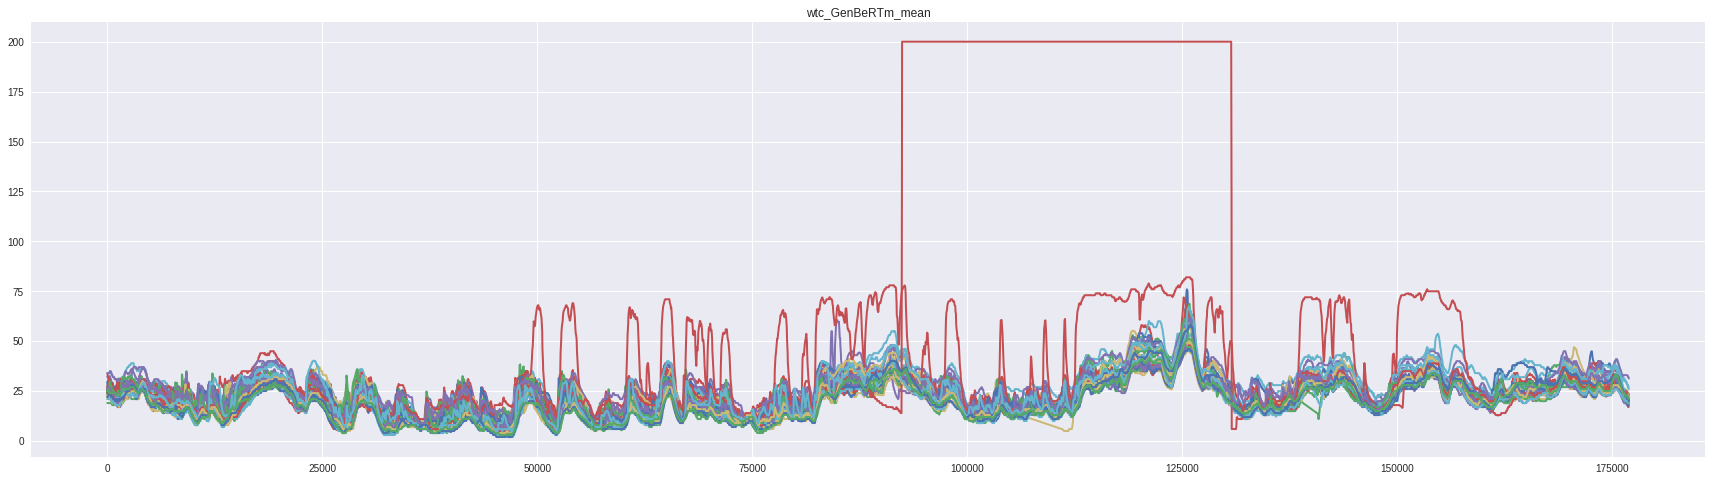

In [14]:
# These are all suprisingly correlated (All from the same farm I'm guessing?)
# What happens if we plot all 44

fig,ax = plt.subplots()

for turbine in data_single_month.StationId.unique():
  data_single_month[data_single_month['StationId'] == turbine].plot(
      y='wtc_GenBeGTm_mean', figsize=(30,8), fig = fig, ax = ax, 
      label='StationId: ' +str(turbine), lw = 2, alpha =1,
      title = 'wtc_GenBeGTm_mean', legend=False)
  
  
  
fig,ax = plt.subplots()

for turbine in data_single_month.StationId.unique():
  data_single_month[data_single_month['StationId'] == turbine].plot(
      y='wtc_GenBeRTm_mean', figsize=(30,8), fig = fig, ax = ax, lw = 2, 
      label='StationId: ' +str(turbine), alpha =1, title = 'wtc_GenBeRTm_mean',
      legend=False)

In [0]:
# Hmm, I wonder which one may have had problems!
# But they actually all do seem highly correlated, which to me only really makes
# sense if they're all from a similar geographical location.
# Could be useful info later on I suppose.

**Data Insights**

* Timeseries Data
* Same geographical location(?)
* Some meaturements are way outside the typical groups (could just do clustering per each timestamp?)
* Occasional sudden (instant?) jumps to 200 degrees, could indicate change out? we'll have to see if we find 3 others.


I don't quite think we're done exploring the data. Now i've got a good handle on the data, lets pull in information from the rest of the year

In [0]:
# Here, we're just going to read in all the frames, and the concatinate them 
# at the end

frames = []

for file in file_locations:
  df = pd.read_csv(file)
  frames.append(df)
  
data = pd.concat(frames, axis = 0)

In [0]:
# Lets also add in to that initial column to a datetime column fo ease of use 
# later

data['DateTime'] = data.TimeStamp.apply(
                          lambda x: pd.to_datetime(x))

In [0]:
# The previous line took a while to run, so lets save this total pandas 
# dataframe so we can load it in much easier later on

data.to_csv(root_path/'full_table.csv')

In [0]:
# and then we can load it back in here

data = pd.read_csv(root_path/'full_table.csv')


healthy_turbine_IDs = [2301750, 2301745, 2301762, 2301728, 
                                        2301752, 2301741]

features = ['TimeStamp','DateTime','StationId','wtc_GenBeGTm_min','wtc_GenBeGTm_mean',
            'wtc_GenBeGTm_max','wtc_GenBeRTm_min','wtc_GenBeRTm_mean',
            'wtc_GenBeRTm_max']

data = data[features]
data['DateTime'] = data.DateTime.apply(pd.to_datetime)

In [20]:
# Lets see if anything much has changed over the year

data.describe()

,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_mean,wtc_GenBeGTm_max,wtc_GenBeRTm_min,wtc_GenBeRTm_mean,wtc_GenBeRTm_max
count,2.138981e+06,2.138973e+06,2.138973e+06,2.138973e+06,2.138974e+06,2.138974e+06,2.138974e+06
mean,2.301743e+06,3.817833e+01,3.846276e+01,3.874999e+01,2.953437e+01,2.977533e+01,3.001755e+01
std,1.268752e+01,1.560444e+01,1.566024e+01,1.572048e+01,1.168526e+01,1.170662e+01,1.173522e+01
min,2.301722e+06,-5.000000e+01,0.000000e+00,0.000000e+00,-5.000000e+01,2.000000e+00,2.000000e+00
25%,2.301733e+06,2.800000e+01,2.800000e+01,2.800000e+01,2.200000e+01,2.200000e+01,2.200000e+01
50%,2.301743e+06,3.700000e+01,3.784092e+01,3.800000e+01,3.000000e+01,3.000000e+01,3.000000e+01
75%,2.301754e+06,4.700000e+01,4.700000e+01,4.700000e+01,3.600000e+01,3.600000e+01,3.600000e+01
max,2.301765e+06,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02


In [21]:
# and once again, are they all valid?
not data.isnull().values.any()

False

In [22]:
#hmm, some invalid data here..


np.where(data.isnull())

# Lets not forget about those.

(array([1130578, 1130578, 1130578, 1130578, 1130578, 1130578, 1174681,
        1174681, 1174681, 1174681, 1174681, 1174681, 1174684, 1174684,
        1174684, 1174684, 1174684, 1174684, 1174706, 1174706, 1174706,
        1174706, 1174706, 1174706, 1510195, 1510195, 1510195, 1510195,
        1510195, 1510195, 1510197, 1510197, 1510197, 1510210, 1510210,
        1510210, 1510210, 1510210, 1510210, 1786707, 1786707, 1786707,
        1786707, 1786707, 1786707]),
 array([3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6,
        7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7,
        8]))

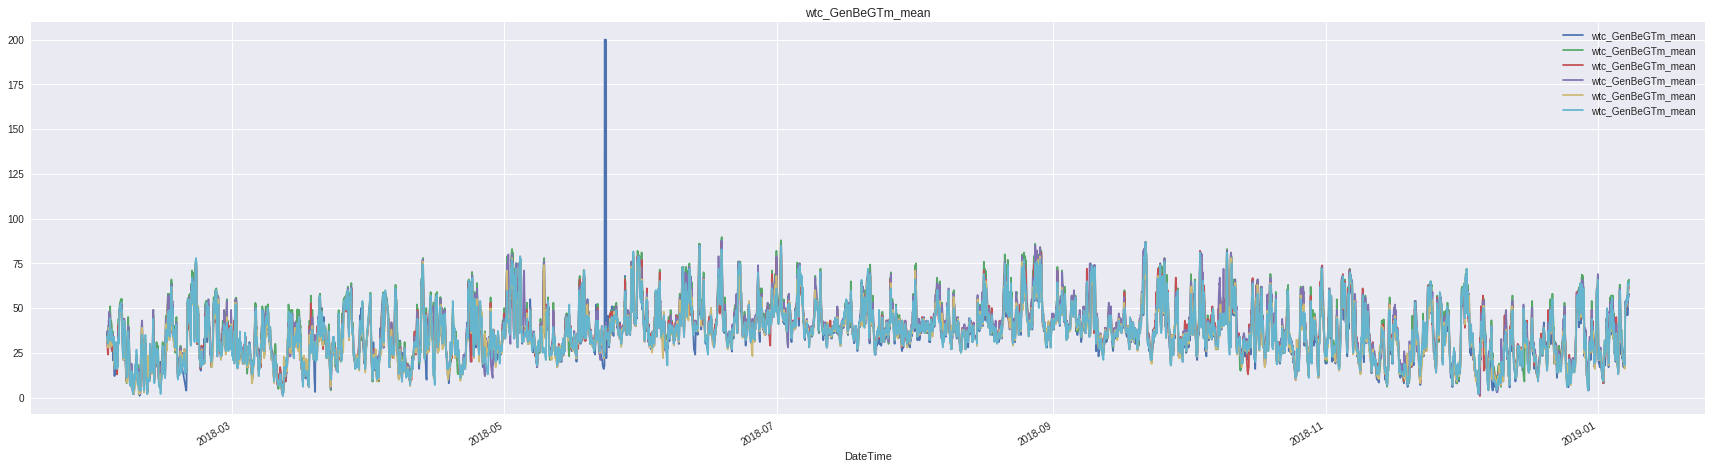

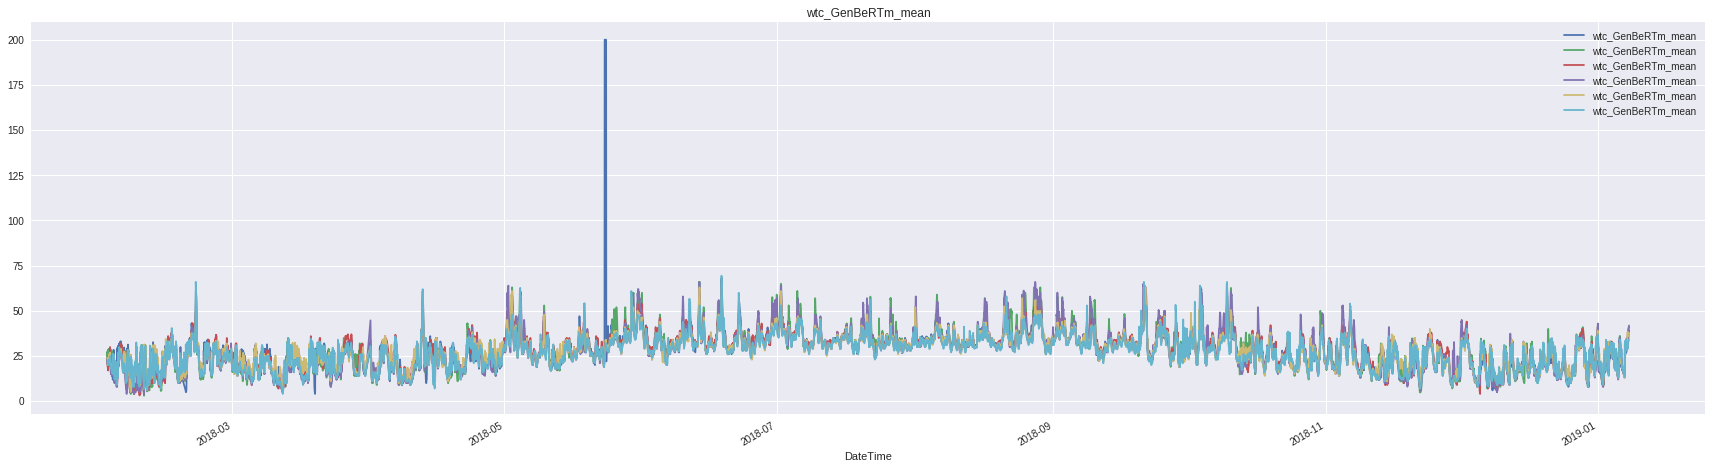

In [23]:
# Nothing huge has change, the typical temperature remains around 38 / 29, with
# extremes of around 0 and 200.

# Lets plot up our healthy turbines again, and compare them to all the turbines


# Lets plot these up as a time series, to get a handle on what they should look
# like

fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='DateTime', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeGTm_mean',)
fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='DateTime', y='wtc_GenBeRTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeRTm_mean',)

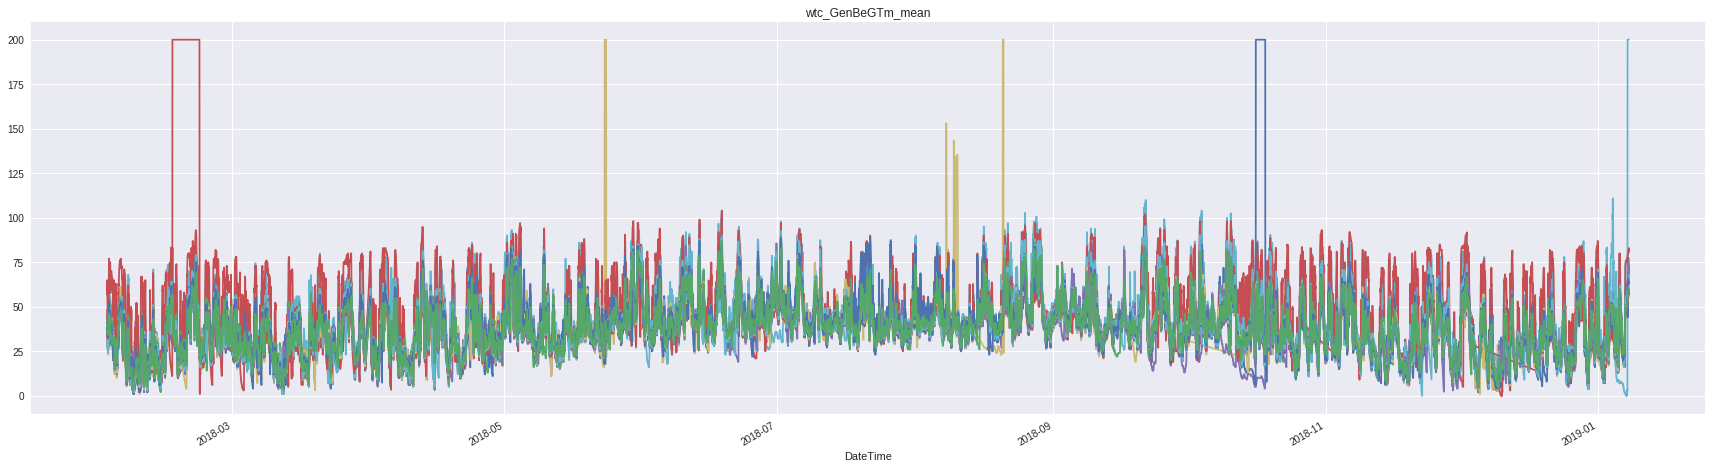

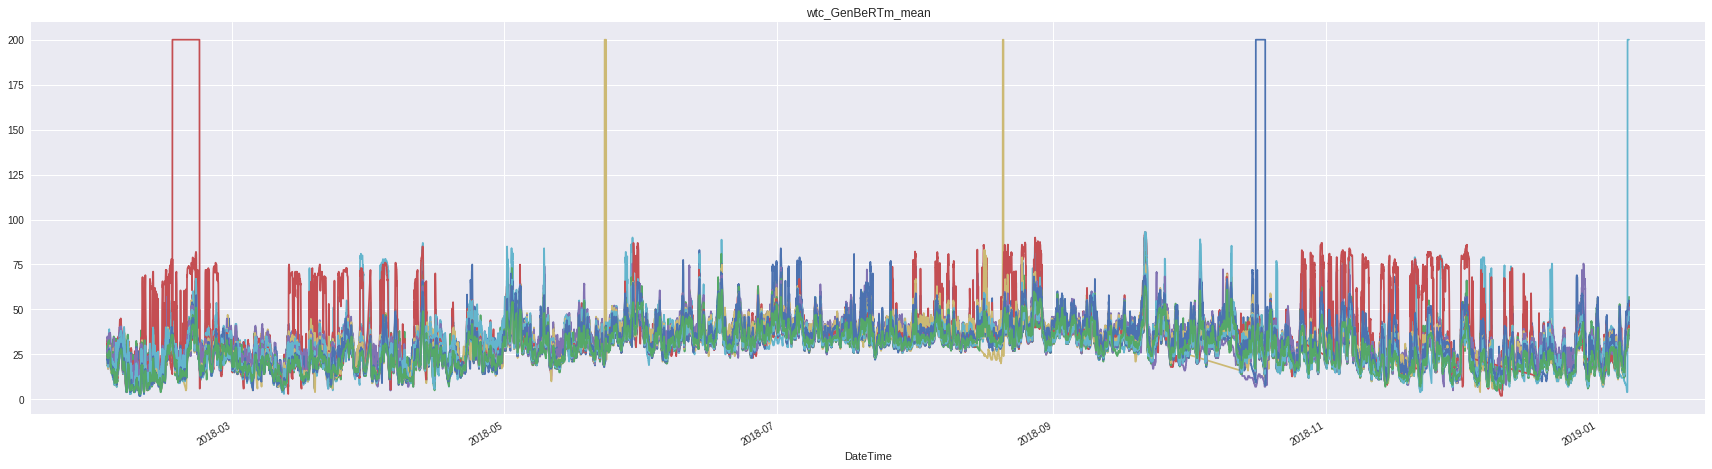

In [24]:
# Really interesting to note the inclusion of a 200+ degrees set of points in a 
# healthy turbine.... will have to be careful here. But it appears its not as 
# the rest of the data is well behaved.

# Lets look at all the data

fig,ax = plt.subplots()

for turbine in data.StationId.unique():
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='DateTime', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeGTm_mean', legend=False)
fig,ax = plt.subplots()

for turbine in data.StationId.unique():
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='DateTime', y='wtc_GenBeRTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeRTm_mean', legend=False)

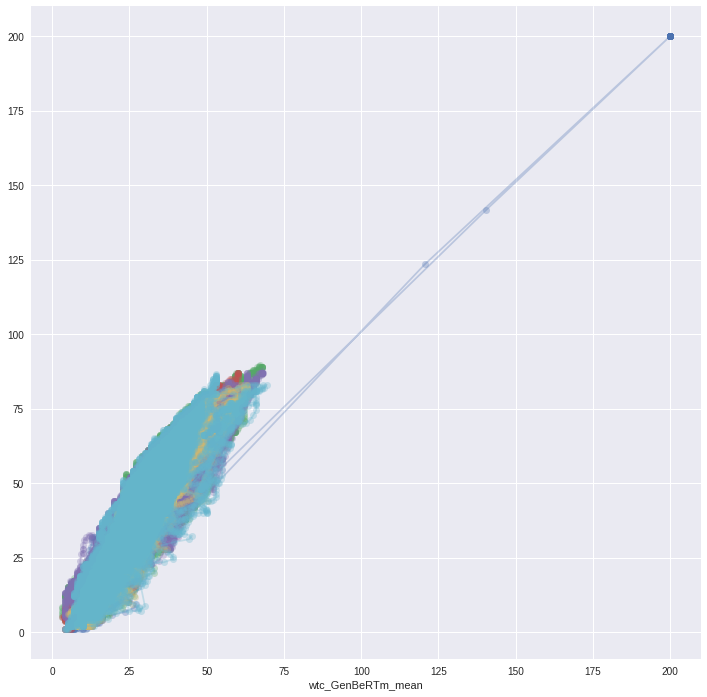

In [25]:
# There's one last thing I want to look at, and that's the plot of the two 
# features we have against each other

# for the known safe turbines:

fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='wtc_GenBeRTm_mean', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(12,12),
                                    legend=False, marker = 'o', alpha = 0.3)

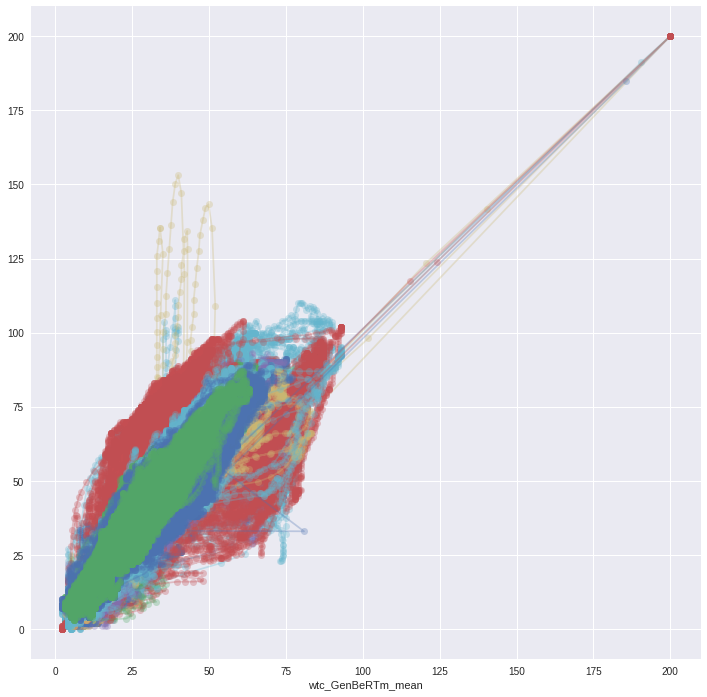

In [26]:
# and for all the sources


fig,ax = plt.subplots()

for turbine in data.StationId.unique():
  turbine_data = data[data['StationId'] == turbine]
  turbine_data.plot(x='wtc_GenBeRTm_mean', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(12,12), 
                                   legend=False, marker = 'o', alpha = 0.3)

**Final thoughts on examining the data**

* The instance of spiking to 200 is clearly an indicator of something strange happening. In fact I would say for four out of five of these, there was a clear fault and it was replaced. In the 5th instance, I can only suspect that a wire had some loose or other such issue, rather than a replacement was needed.
* That isn't to say those are the only issues; there are clearly some turbines that are running hotter than others, especially when the wind picks up. Given the clear summer/winter curve and correlation between individual turbines, it's fairly clear to me that these are all at the same location, so I can't think otherwise of a good reason why some would run hotter than others except in the case of a potential fault
* I don't particularly have the subject matter knowledge to know if these hotter running turbines *are* indications of a fault, but they *are* anomalous with respect to the other turbines.

With that in mind, I think the simplest way to model anomalous turbines is going to be comparing all turbines to some kind of average turbine, and see which ones are strong deviations from that.

## Model Creation, Version 1

In [0]:
# Lets begin by grouping our data into days

data['dayofyear'] = data.DateTime.apply(lambda x: x.dayofyear)

In [0]:
data_grouped_day = data.groupby(by='dayofyear')

In [0]:
# Now we can calculate the mean temperatures and standard deviations
# For each day, a moving average if you will.

mean_per_day = data_grouped_day.mean()
std_per_day = data_grouped_day.std()

In [0]:
# Lets now create a function that calculates the deviation from the average 
# turbine on a given day for a given feature

def find_deviation(day = 32, feature = 'wtc_GenBeGTm_mean',
                  data = data, mean_per_day = mean_per_day, 
                  std_per_day = std_per_day):

  '''
  Returns a Series which gives the deviation of a given feature on a 
  particular day
  
  '''
  test = data[data['dayofyear'] == day]
  test_m = mean_per_day[mean_per_day.index == day]
  test_s = std_per_day[std_per_day.index == day]

  abs_deviation = (test[feature] - test_m[feature].values)
  norm_deviation = abs_deviation/test_s[feature].values
  
  return norm_deviation

In [31]:
# As a test case, lets just look at the first day of the data

data_day_32 = data[data['dayofyear'] == 32]
data_day_32['GT_Deviation'] = find_deviation(day=32, 
                                             feature = 'wtc_GenBeGTm_mean')
data_day_32['RT_Deviation'] = find_deviation(day=32, 
                                             feature = 'wtc_GenBeRTm_mean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
# And now lets see where that deviation is signifiant
# [5 sigma is a typical threshold used in my work, corresonds roughly to a 
# 1 in 10,000 random chance of occuring]

data_day_32[
    (data_day_32['GT_Deviation'] > 5) | (data_day_32['RT_Deviation'] > 5)]

,TimeStamp,DateTime,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_mean,wtc_GenBeGTm_max,wtc_GenBeRTm_min,wtc_GenBeRTm_mean,wtc_GenBeRTm_max,dayofyear,GT_Deviation,RT_Deviation
2503,2/1/18 9:20,2018-02-01 09:20:00,2301754,75.0,75.169952,76.0,28.0,28.936131,29.0,32,5.045462,1.195568
2533,2/1/18 9:30,2018-02-01 09:30:00,2301754,76.0,76.000000,76.0,29.0,29.000000,29.0,32,5.159158,1.211348
2577,2/1/18 9:40,2018-02-01 09:40:00,2301754,76.0,76.077469,77.0,29.0,29.544479,30.0,32,5.169769,1.345876
2613,2/1/18 9:50,2018-02-01 09:50:00,2301754,76.0,76.997353,77.0,30.0,30.000000,30.0,32,5.295770,1.458423
2679,2/1/18 10:00,2018-02-01 10:00:00,2301754,77.0,77.000000,77.0,30.0,30.000000,30.0,32,5.296133,1.458423
2721,2/1/18 10:10,2018-02-01 10:10:00,2301754,77.0,77.000000,77.0,30.0,30.006399,31.0,32,5.296133,1.460005
2753,2/1/18 10:20,2018-02-01 10:20:00,2301754,77.0,77.000000,77.0,30.0,30.579201,31.0,32,5.296133,1.601530
2811,2/1/18 10:30,2018-02-01 10:30:00,2301754,76.0,76.754227,77.0,30.0,30.760929,31.0,32,5.262468,1.646430
2855,2/1/18 10:40,2018-02-01 10:40:00,2301754,75.0,75.364281,76.0,30.0,30.000000,30.0,32,5.072081,1.458423
3997,2/1/18 15:00,2018-02-01 15:00:00,2301754,75.0,75.000000,75.0,29.0,29.205700,30.0,32,5.022183,1.262171


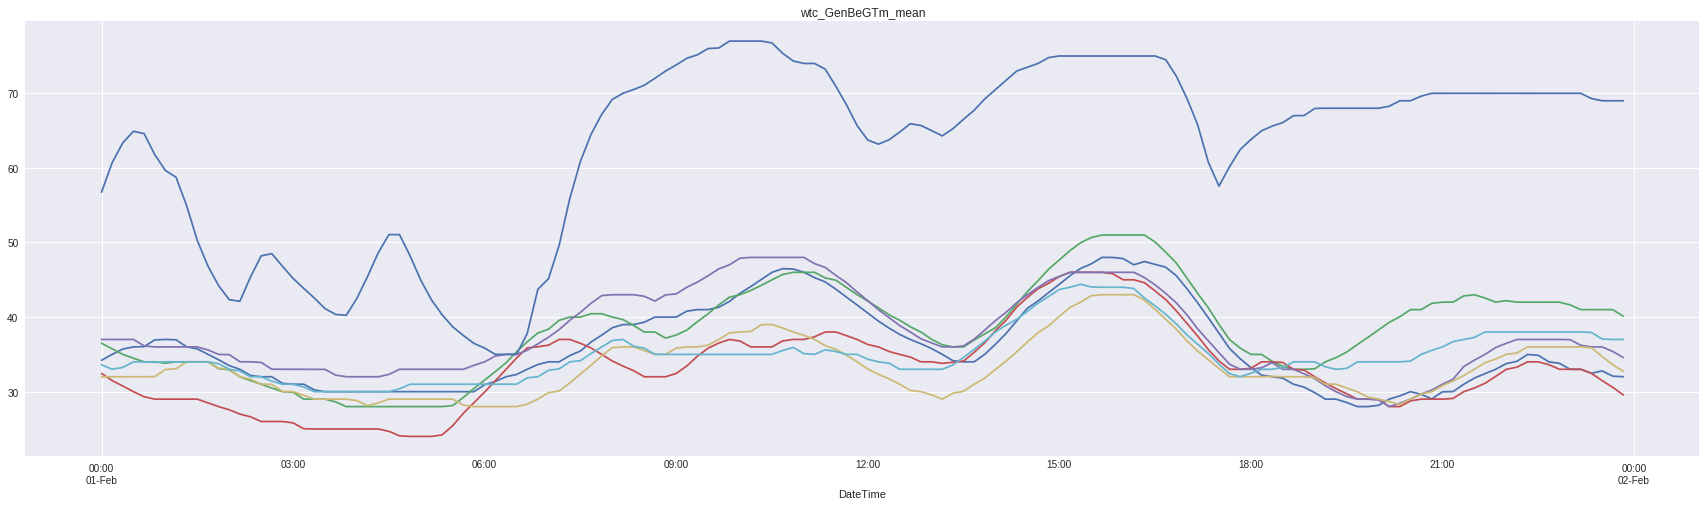

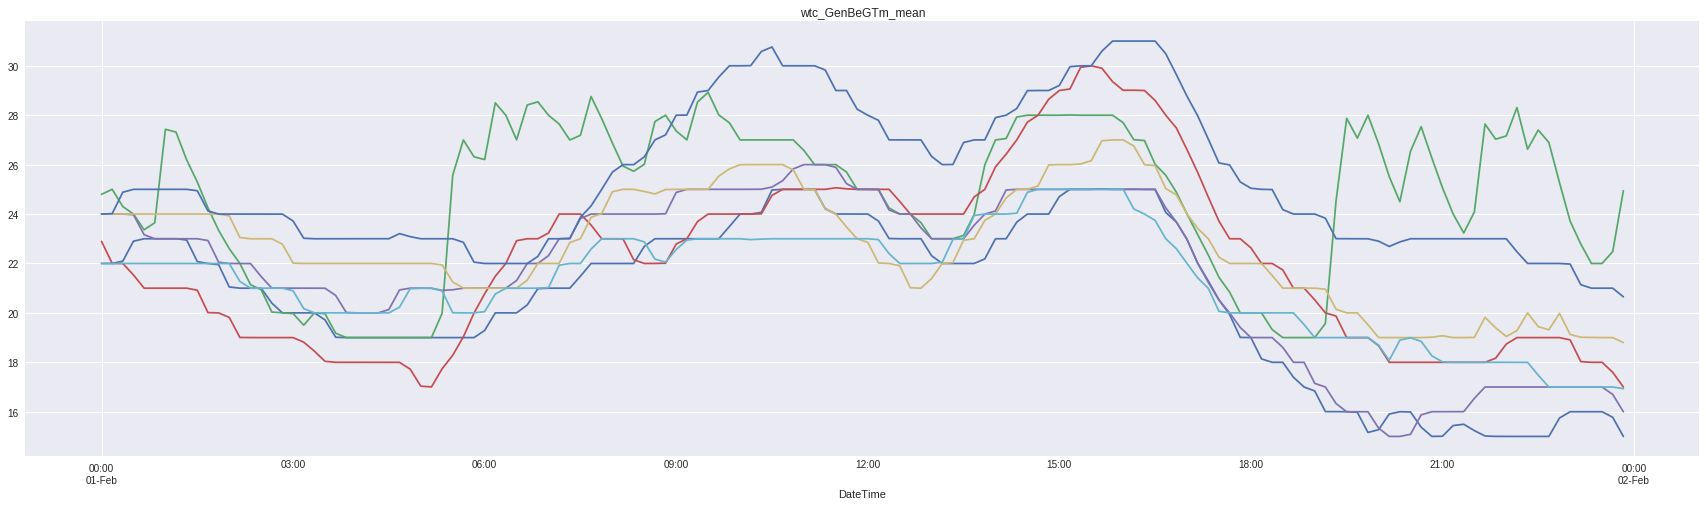

In [63]:
# Interesting, all one Station ID: 2301754.
# More interesting perhaps is although its deviant with respect to 
# wtc_GenBeGTm_mean, it's not as much to wtc_GenBeRTm_mean.
# Without more subject knowledge its difficult to say.
# I'll plot these up for now


fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  turbine_data = data_day_32[(data_day_32['StationId'] == turbine) & (data_day_32['dayofyear'] == 32)]
  turbine_data.plot(x='DateTime', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeGTm_mean', legend=False)
  
for turbine in [2301754]:
  turbine_data = data_day_32[(data_day_32['StationId'] == turbine) & (data_day_32['dayofyear'] == 32)]
  turbine_data.plot(x='DateTime', y='wtc_GenBeGTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeGTm_mean', legend=False)
  
fig,ax = plt.subplots()

for turbine in healthy_turbine_IDs:
  turbine_data = data_day_32[(data_day_32['StationId'] == turbine) & (data_day_32['dayofyear'] == 32)]
  turbine_data.plot(x='DateTime', y='wtc_GenBeRTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeRTm_mean', legend=False)

for turbine in [2301754]:
  turbine_data = data_day_32[(data_day_32['StationId'] == turbine) & (data_day_32['dayofyear'] == 32)]
  turbine_data.plot(x='DateTime', y='wtc_GenBeRTm_mean', 
                                   fig = fig, ax = ax, figsize=(30,8),
                                   title = 'wtc_GenBeGTm_mean', legend=False)

In [35]:
# Let's do this for all the days, and pull out the unique StationID's that show
# These kind of deviations; they're suspicious at the least. I'll also require
# both means to show a deviation for any actionable events

suspicious_turbines = []

for day in np.arange(1,366):
  data_day_i = data[data['dayofyear'] == day]
  data_day_i['GT_Deviation'] = find_deviation(day=day, 
                                             feature = 'wtc_GenBeGTm_mean')
  data_day_i['RT_Deviation'] = find_deviation(day=day, 
                                             feature = 'wtc_GenBeRTm_mean')
  deviants = data_day_i[
    (data_day_i['GT_Deviation'] > 5) & (data_day_i['RT_Deviation'] > 5)]
  
  unique_turbines = deviants.StationId.unique()
  
  for ID in unique_turbines:
    if ID not in suspicious_turbines:
      suspicious_turbines.append(ID)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [36]:
# Which leaves us with the following 8 supicious turbines

suspicious_turbines

[2301727, 2301754, 2301760, 2301750, 2301764, 2301744, 2301758, 2301733]

In [37]:
# Only one of which appears in the known "no faults" list, and I suspect that 
# this turbine too was suspected initially of having a fault.

for i in healthy_turbine_IDs:
  print(i in suspicious_turbines)

True
False
False
False
False
False


## Alternative method - Using PCA and the Mahalanobis distance

In [0]:
# Given we're wanting to compare the typical ensamble of turbines to a new turbine
# to see if it is considered normal or abnormal, we should be more careful about
# how we're measuring distance.

# In the previous example, we simply took the standard deviation, which is 
# effectively symettrical in space (i.e. a sphere). But the distribution of our
# data isn't nessercerilly spherical, and so we should include the covariance
# terms in order to give a first approximation to the "shape" of our data.

# We also didn't include all the data, only 2 features. Whilst for something 
# Reasonably simple like the 6 features we had, if we were to go back up to 100+
# features we would no longer be able to pick out interesting features by eye.

# So, there are two things we need to address
# 1) Include all features in our model
# 2) Be more careful about distances


# To solve 1), we can use PCA and then look for how many components we need 
# to explain most of the variance. To solve 2) instead of eucldian distance we 
# can use the Mahalanobis distance, which can be thought of as a distance which
# grows as a point moves away from the mean along each principal component axis.




from sklearn.decomposition import PCA

In [0]:
# I did some quick testing, and found we could explain 99% of the variance with 
# only two components.

pca = PCA(2)

In [0]:
# Lets get some data out and transform it using our pca object.

data_window = data[data['dayofyear'] == 33]

X = data_window[['wtc_GenBeGTm_min',
 'wtc_GenBeGTm_mean',
 'wtc_GenBeGTm_max',
 'wtc_GenBeRTm_min',
 'wtc_GenBeRTm_mean',
 'wtc_GenBeRTm_max','StationId']].values

projected = pca.fit_transform(X[:,:-1])    # Don't include the StationId in the
                                           # PCA

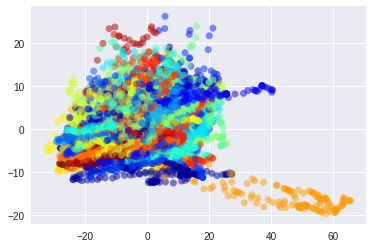

In [41]:
# Lets have a quick look at this...

plt.scatter(projected[:, 0], projected[:, 1],
            c=data_window.StationId.values, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('jet') )

In [0]:
# Which shows a fairly clear odd result.

In [0]:
# Rather than calculating the Mahalanobis distance for all of these
# I'm going to take the mean position of each turbine in this plot,
# and then assume the normal behaving turbines overwhelm those with faults,
# such that I can still get a good idea of the shape of the distribution in this
# PCA plot, eventhough it may include outliers.
# I will however use the means over the day, to remove day variations from the
# plot.

# Get the mean positions of our sample over the course of whatever
# Window function we've chosen

turbine_list = np.unique(X[:,-1])
mean_positions = np.array([0,0])
for turbine in turbine_list:
  mean_position = np.mean(projected[np.where(X[:,-1] == turbine),:], axis = 1)
  mean_positions = np.append(mean_positions, mean_position)
mean_positions = mean_positions[2:].reshape([-1,2])

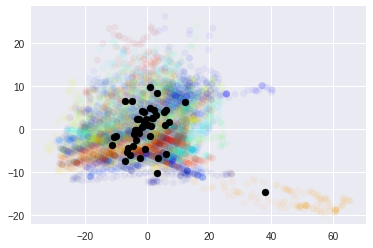

In [44]:
# Lets plot these centroids up

plt.scatter(projected[:, 0], projected[:, 1],
            c=data_window.StationId.values, edgecolor='none', alpha=0.05, 
            cmap=plt.cm.get_cmap('jet') )
plt.scatter(mean_positions[:,0], mean_positions[:,1], color='k')

In [0]:
# For each of these, we can now calculate the Mahalanobis distance, which unlike
# our earlier standard deviation route, includes information from the confusion
# matrix, and therefore the `shape' of the distribution

maha_distances = []
for i in turbine_list:
  cov = np.matrix(np.cov(np.transpose(mean_positions)))
  u = np.matrix(np.mean(mean_positions, axis = 0))
  x = np.matrix(np.mean(pca.transform(X[X[:,-1] == i][:,:-1]), axis = 0))
  dist = ((x.T-u.T).T) * np.linalg.inv(cov) * (x.T - u.T)
  maha_distances.append(float(np.sqrt(dist[0])))

(array([5., 2., 4., 4., 1., 4., 3., 2., 1., 4., 5., 2., 0., 2., 1., 2., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.193288  , 0.31129671, 0.42930543, 0.54731415, 0.66532286,
        0.78333158, 0.90134029, 1.01934901, 1.13735773, 1.25536644,
        1.37337516, 1.49138388, 1.60939259, 1.72740131, 1.84541002,
        1.96341874, 2.08142746, 2.19943617, 2.31744489, 2.4354536 ,
        2.55346232, 2.67147104, 2.78947975, 2.90748847, 3.02549718,
        3.1435059 , 3.26151462, 3.37952333, 3.49753205, 3.61554076,
        3.73354948, 3.8515582 , 3.96956691, 4.08757563, 4.20558434,
        4.32359306, 4.44160178, 4.55961049, 4.67761921, 4.79562793,
        4.91363664, 5.03164536, 5.14965407, 5.26766279, 5.38567151]),
 <a list of 44 Patch objects>)

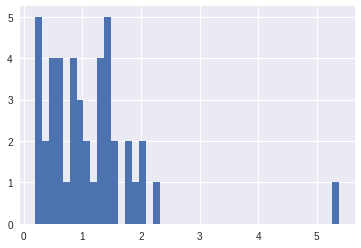

In [46]:
plt.hist(maha_distances, bins = 44)

In [0]:
# We can put all the above into a single function...

def get_suspicious_turbines(day, sigma = 5):
  
  from sklearn.decomposition import PCA
  
  pca = PCA(2)
  
  data_window = data[data['dayofyear'] == day]

  X = data_window[['wtc_GenBeGTm_min',
   'wtc_GenBeGTm_mean',
   'wtc_GenBeGTm_max',
   'wtc_GenBeRTm_min',
   'wtc_GenBeRTm_mean',
   'wtc_GenBeRTm_max','StationId']].values
  
  if np.any(np.isnan(X)):
    print('Skipping day {0} due to invalid data'.format(day))
    return None
  
  
  projected = pca.fit_transform(X[:,:-1])    # Don't include the StationId in the
                                             # PCA
    
    
  # Get the mean positions of our sample over the course of whatever
  # Window function we've chosen

  turbine_list = np.unique(X[:,-1])
  mean_positions = np.array([0,0])
  for turbine in turbine_list:
    mean_position = np.mean(projected[np.where(X[:,-1] == turbine),:], axis = 1)
    mean_positions = np.append(mean_positions, mean_position)
  mean_positions = mean_positions[2:].reshape([-1,2])
  
  
  maha_distances = []
  for i in turbine_list:
    cov = np.matrix(np.cov(np.transpose(mean_positions)))
    u = np.matrix(np.mean(mean_positions, axis = 0))
    x = np.matrix(np.mean(pca.transform(X[X[:,-1] == i][:,:-1]), axis = 0))
    dist = ((x.T-u.T).T) * np.linalg.inv(cov) * (x.T - u.T)
    maha_distances.append(float(np.sqrt(dist[0])))
    
  maha_distances = np.asarray(maha_distances)
  
  suspicious_turbines = turbine_list[np.where(maha_distances > sigma)]
  suspicious_turbines = [int(i) for i in suspicious_turbines]
  
  return suspicious_turbines
                                

In [52]:
get_suspicious_turbines(33, sigma = 5)

[2301754]

In [53]:
# and then we can doing this for the whole year, i.e. all the data.

suspicious = []

for i in range(1,8):
  questionable_turbines = get_suspicious_turbines(i, sigma = 5)
  if questionable_turbines == None:
    continue
  for turbine in questionable_turbines:
    if turbine not in suspicious:
      suspicious.append(turbine)
      
for i in range(32,366):
  questionable_turbines = get_suspicious_turbines(i, sigma = 5)
  if questionable_turbines == None:
    continue
  for turbine in questionable_turbines:
    if turbine not in suspicious:
      suspicious.append(turbine)

Skipping day 212 due to invalid data
Skipping day 219 due to invalid data
Skipping day 272 due to invalid data
Skipping day 317 due to invalid data


In [0]:
# You can even see the days with invalid data!

In [55]:
# And we are left with the following 9 turbines which at some point during the 
# year were flagged as being anomalous! 
suspicious

[2301727,
 2301754,
 2301760,
 2301733,
 2301750,
 2301744,
 2301765,
 2301737,
 2301758]

In [0]:
# Lets compare this with our previous idetifications of strange turbines

previous_suspicious = [2301727, 2301754, 2301760, 2301750, 2301764, 2301744, 2301758, 2301733]

In [57]:
for i in suspicious:
  print(i in previous_suspicious)

True
True
True
True
True
True
False
False
True


In [58]:
for i in previous_suspicious:
  print(i in suspicious)

True
True
True
True
False
True
True
True


In [60]:
# And again we can see only one of our `healthy' turbines is suspicious

for i in healthy_turbine_IDs:
  print(i in suspicious)

True
False
False
False
False
False


In [0]:
# So these two methods agree quite tightly, with the exception of turbines 
# 2301750, 2301744, 2301758

# Given the second method is much more scalable and more directly ML related,
# I'll submit that one.